<a href="https://colab.research.google.com/github/MichaelArthur224/Project-2/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coding Dojo/ML Week 3/healthcare-dataset-stroke-data.csv')
df1 = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

##Data Cleaning

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
#Filled missing bmi with average
df.fillna({"bmi":df['bmi'].mean().round(1)}, inplace=True)
df['bmi'].head()

0    36.6
1    28.9
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [8]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [9]:
#Since there is only 1 other gender I will change it to male to be easier to work with there is also less males than females in the data set
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [10]:
df['gender'] = df['gender'].replace('Other', 'Male')
df.loc[df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [11]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [12]:
#As of now I have not decided to drop any columns. I want to develop a plan and see what will be used and what will not be used.

##Exploratory

From your data analysis, create two visuals that demonstrate key findings of interest to a stakeholder. These visuals should be reporting quality. Be sure to explain the finding associated with each visual. (NO histograms, boxplots, or correlation plots)

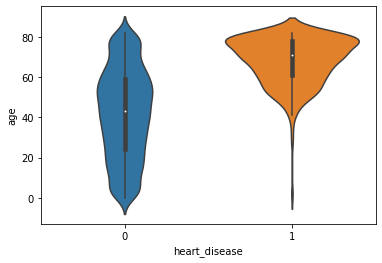

In [58]:
sns.violinplot(data=df, x='heart_disease', y='age')

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
You can see that people of older age have heart disease, meanwhile the amount of younger people without heart disease is greater

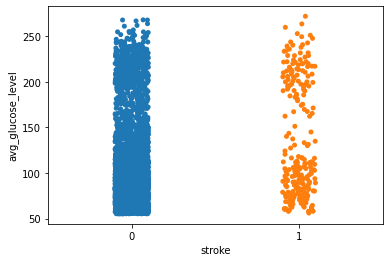

In [66]:
sns.stripplot(data=df, x='stroke', y='avg_glucose_level')

stroke: 1 if the patient had a stroke or 0 if not
The amount of people with a glucose level around 150 seem to have the least amount of strokes

When viewing these graphs you can see what age group and what glucose level we need to research more in depth